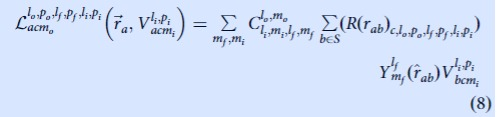

In [1]:
from IPython.display import Image, display
display(Image(filename=r'c:\Users\Lenovo\Downloads\6519d23c-08bc-496a-8bf7-4c9bd60e3917.jpg'))

In [2]:
'''以下对所有的所需要用到并且需要明确的参数进行说明：
1.  num_species: 原子种类数
2.  num_embeddings: 对原子标签Embedding映射得到的嵌入维度
3.  r_c: 截断半径
4.  num_basis: 径向基映射得到的基函数数量，也是R_Embedding的输出维度
5.  num_layers: 卷积层数
6.  l_max: 设定球谐函数最大阶数，也是
7.  single_atom_num: 单个分子里所含原子数目
8.  batch_size: 一个批次处理的总原子数目
9.  hidden_dims: MLP隐藏层维度
10. channel_per_l: dict,表示每个l的通道数
11. max_z: 最大原子序数,也是Embedding的输入维度
12. neighbor_mask: 用于表示邻居mask的张量，形状为[batch_size, single_atom_num, single_atom_num]
13. sample_num:样本数
14. rho:表示损失函数中力损失占比'''


'以下对所有的所需要用到并且需要明确的参数进行说明：\n1.  num_species: 原子种类数\n2.  num_embeddings: 对原子标签Embedding映射得到的嵌入维度\n3.  r_c: 截断半径\n4.  num_basis: 径向基映射得到的基函数数量，也是R_Embedding的输出维度\n5.  num_layers: 卷积层数\n6.  l_max: 设定球谐函数最大阶数，也是\n7.  single_atom_num: 单个分子里所含原子数目\n8.  batch_size: 一个批次处理的总原子数目\n9.  hidden_dims: MLP隐藏层维度\n10. channel_per_l: dict,表示每个l的通道数\n11. max_z: 最大原子序数,也是Embedding的输入维度\n12. neighbor_mask: 用于表示邻居mask的张量，形状为[batch_size, single_atom_num, single_atom_num]\n13. sample_num:样本数\n14. rho:表示损失函数中力损失占比'

In [3]:
#对所需要用到且需要定义的参数进行统一定义
num_species = 3
num_embeddings = 32
r_c = 5.0
num_basis = 8
num_layers = 3
l_max = 3
single_atom_num = 10 #可在数据处理时得到
batch_size =32 #会根据每次处理的分子数量而变化
hidden_dims = [164, 32]
channels_per_l = {0:64, 1:32, 2:16,3:8} #每个l的通道数
max_z = 100
sample_num =5000 #样本数
rho = 0.2 #力损失占比

In [4]:
import numpy as np
import torch
import torch.nn as nn
from find_neighbor import build_adjacent_pairs_torch
from torch.nn.functional import mse_loss

def read_xyz_molecule(file_path,sample_num):
    data = []
    energies = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        single_atom_num = int(lines[0])
    for i in range(sample_num):
        energies.append(float(lines[1 + (single_atom_num+2)*i]))
        for line in lines[2+(single_atom_num+2)*i : 2+(single_atom_num+2)*i + single_atom_num]:
            parts = line.split()
            atom_type = parts[0]
            x, y, z, Fx, Fy, Fz = map(float, parts[1:7])
            data.append([atom_type, x, y, z, Fx, Fy, Fz])
    return np.array(data, dtype=object), np.array(energies, dtype=float).reshape(-1,1),single_atom_num



file_path = r"C:\Users\Lenovo\Desktop\pytorch\benzene_old_dft.xyz"
#读取数据
data, energies ,single_atom_num =read_xyz_molecule(file_path,sample_num)
# 随机打乱分子索引
indices = np.random.permutation(sample_num)
split_train = int(0.2 * sample_num) 


train_idx = indices[:split_train]
test_idx  = indices[split_train:]

# 根据打乱索引提取数据（每个分子占据12行）
def index_data(idx_list):
    data_out = data[np.concatenate([np.arange(i*12, (i+1)*12) for i in idx_list])]
    energies_out = energies[idx_list]
    return data_out, energies_out


data_train, energies_train = index_data(train_idx)
data_test, energies_test = index_data(test_idx)


atom_map = {
    'H': 1, 'He': 2,

    'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,

    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,

    'K': 19, 'Ca': 20, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36,
 
    'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 
    
    'Ni': 28, 'Cu': 29, 'Zn': 30,

    'Ag': 47, 'Au': 79, 'Pt': 78, 'Pd': 46, 'Hg': 80, 'Pb': 82, 'Sn': 50,

    'I': 53, 'Xe': 54, 'Ba': 56, 'W': 74, 'U': 92
}

def extract(arr):
    types = np.vectorize(atom_map.get)(arr[:,0])
    coords = arr[:,1:4].astype(np.float64)
    forces = arr[:,4:7].astype(np.float64)
    return types, coords, forces
t_train, X_train, F_train = extract(data_train)

X_train = X_train.reshape(-1,12,3)
F_train = F_train.reshape(-1,12,3)
t_train = t_train.reshape(-1,12)

t_test, X_test, F_test = extract(data_test)
X_test = X_test.reshape(-1,12,3)
F_test = F_test.reshape(-1,12,3)
t_test = t_test.reshape(-1,12)

# 能量
E_train = energies_train.reshape(-1).astype(np.float64)
std_energies = torch.tensor(np.std(E_train))
E_test  = energies_test.reshape(-1).astype(np.float64)

X_train_rel = torch.from_numpy(X_train)
X_test_rel  = torch.from_numpy(X_test)

train_inputs = torch.cat([torch.from_numpy(t_train[:,:,None].astype(np.float64)),X_train_rel], dim=2)
test_inputs  = torch.cat([torch.from_numpy(t_test[:,:,None].astype(np.float64)),X_test_rel], dim=2)
temp = E_train.mean()
train_E = torch.from_numpy(E_train)
train_E= train_E - temp  
train_F = torch.from_numpy(F_train)
test_E  = torch.from_numpy(E_test)
test_E = test_E - temp  
test_F  = torch.from_numpy(F_test)

from torch_geometric.data import Data, DataLoader
data_list = []
for inp, E, F in zip(train_inputs, train_E, train_F):
    z   = inp[:, 0].long()
    pos = inp[:, 1:].float()
    data_list.append(Data(z=z, pos=pos, y=E.view(1), force=F))
train_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)



#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
#模型导入
from NequIPModel import NequIPModel
model = NequIPModel(
    l_max = l_max,
    channels_per_l=channels_per_l,
    num_basis=num_basis,
    num_layers=num_layers, 
    max_z=max_z,
    conv_kwargs=None
).to(device)

print(model)

NequIPModel(
  (embedding): Embedding(100, 64)
  (blocks): ModuleList(
    (0-2): 3 x InteractionBlock(
      (conv): EquivariantConvLayer(
        (r_emb): R_Embedding(
          (mlp): Sequential(
            (0): Linear(in_features=16, out_features=64, bias=True)
            (1): SiLU()
            (2): Linear(in_features=64, out_features=32, bias=True)
            (3): SiLU()
            (4): Linear(in_features=32, out_features=8, bias=True)
          )
        )
        (mix): ModuleDict(
          (0_0_0): Linear(in_features=64, out_features=64, bias=False)
          (0_1_1): Linear(in_features=64, out_features=32, bias=False)
          (0_2_2): Linear(in_features=64, out_features=16, bias=False)
          (0_3_3): Linear(in_features=64, out_features=8, bias=False)
          (1_0_1): Linear(in_features=32, out_features=32, bias=False)
          (1_1_0): Linear(in_features=32, out_features=64, bias=False)
          (1_1_1): Linear(in_features=32, out_features=32, bias=False)
     

In [6]:
#训练参数设置
times  =100
mse_loss = nn.MSELoss()
#优化器
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)

def luncf(E_pred, E_true, F_pred, F_true,rho):
    loss_E = mse_loss(E_pred, E_true)
    loss_F = mse_loss(F_pred, F_true)
    return loss_E + loss_F*rho

Epoch   1 | Loss: 1312.628441
Epoch   2 | Loss: 1265.980694
Epoch   3 | Loss: 1260.296249
Epoch   4 | Loss: 1259.697224
Epoch   5 | Loss: 1256.223732
Epoch   6 | Loss: 1251.290264
Epoch   7 | Loss: 1012.368973
Epoch   8 | Loss: 563.924549
Epoch   9 | Loss: 386.540439
Epoch  10 | Loss: 291.393310
Epoch  11 | Loss: 275.287693
Epoch  12 | Loss: 240.884066
Epoch  13 | Loss: 248.480440
Epoch  14 | Loss: 229.227029
Epoch  15 | Loss: 203.005164
Epoch  16 | Loss: 191.161931
Epoch  17 | Loss: 182.050279
Epoch  18 | Loss: 174.802904
Epoch  19 | Loss: 168.470265
Epoch  20 | Loss: 170.533633
Epoch  21 | Loss: 153.293589
Epoch  22 | Loss: 148.331065
Epoch  23 | Loss: 143.898713
Epoch  24 | Loss: 140.712280
Epoch  25 | Loss: 128.484575
Epoch  26 | Loss: 126.337021
Epoch  27 | Loss: 148.776246
Epoch  28 | Loss: 126.138106
Epoch  29 | Loss: 110.944031
Epoch  30 | Loss: 110.996728
Epoch  31 | Loss: 106.969198
Epoch  32 | Loss: 107.856869
Epoch  33 | Loss: 97.847612
Epoch  34 | Loss: 127.603477
Epoch  3

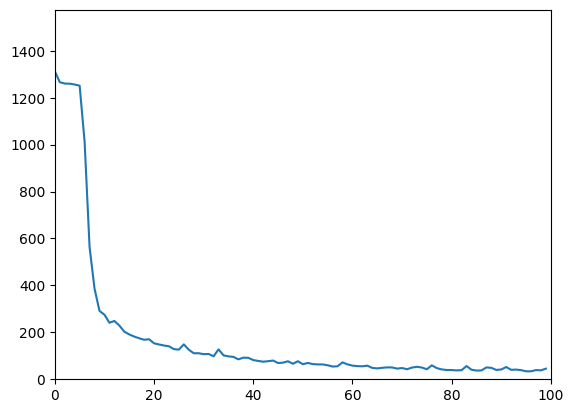

In [7]:
import matplotlib.pyplot as plt
train_loss_per_epoch = []
totel_times =0 
for epoch in range(times):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch_size = int(batch.z.size(0)/single_atom_num)  # 获取当前批次的分子数量
        batch = batch.to(device)
        batch.z = batch.z.long().view(batch_size,-1)  # 确保原子类型是整数
        batch.y = batch.y.float()  # 确保能量是浮点数
        batch.force = batch.force.float().view(batch_size,-1,3)
        batch.pos = batch.pos.clone().detach().requires_grad_(True).float().view(batch_size,-1,3)  # 确保位置是可微的
        neighbor_mask = build_adjacent_pairs_torch(batch.pos, r_c)
        optimizer.zero_grad()
        E_pred,F_pred = model(batch.z,batch.pos,neighbor_mask=neighbor_mask) 
        F_true = batch.force
        # 计算联合损失
        loss =luncf(E_pred,batch.y,F_pred,F_true,rho)
        loss.backward()
        #print("Param grad:", model.interactions[0].lin.weight.grad.abs().mean().item())
        optimizer.step()
        total_loss += loss.item()
    train_loss_per_epoch.append(total_loss)
    scheduler.step()
    print(f"Epoch {epoch+totel_times+1:3d} | Loss: {total_loss:.6f}")
    
plt.plot(train_loss_per_epoch)
plt.xlim(left=totel_times,right =totel_times+times )
plt.ylim(top=max(train_loss_per_epoch[totel_times:totel_times+times])*1.2, bottom=min(min(train_loss_per_epoch[totel_times:totel_times+times])-0.5,0))
plt.show()
totel_times+=times

#模型保存
torch.save(model.state_dict(), r"C:\Users\Lenovo\Desktop\pytorch\E3\model.pth")


In [8]:
#加载模型
model.load_state_dict(torch.load( r"C:\Users\Lenovo\Desktop\pytorch\E3\model.pth",map_location=device))
model.eval()
# 构建测试集 DataLoader
test_data_list = []
for inp, E, F in zip(test_inputs, test_E, test_F):
    z   = inp[:, 0].long()
    pos = inp[:, 1:].float()
    data = Data(
        z=z,
        pos=pos,
        y=E.unsqueeze(0),
        force=F
    )
    test_data_list.append(data)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

E_err = []
#模型测试

def test(model, test_loader, device='cuda'):
    total_loss_E = 0.0
    total_loss_F = 0.0
    total_samples = 0
    for batch in test_loader:
        batch = batch.to(device)
        batch_size = int(batch.z.size(0)/single_atom_num)  # 获取当前批次的分子数量
        batch.y = batch.y.float()  # 确保能量是浮点数
        batch.z = batch.z.long().view(batch_size,-1)  # 确保原子类型是整数
        batch.force = batch.force.float().view(batch_size,-1,3)
        batch.pos = batch.pos.clone().detach().requires_grad_(True).float().view(batch_size,-1,3)  # 确保位置是可微的
        # 能量预测
        neighbor_mask = build_adjacent_pairs_torch(batch.pos, r_c)
        E_pred,F_pred = model(batch.z,batch.pos,neighbor_mask=neighbor_mask)   #
        # 真值
        E_true = batch.y.view(-1)      # [batch_size]
        F_true = batch.force           # [total_nodes, 3]
        print("F_pred:",F_pred)
        print("F_true:",F_true)

        # 计算误差
        loss_E = mse_loss(E_pred, E_true)
        loss_F = mse_loss(F_pred, F_true)
        E_err.append(E_pred-E_true)
        total_loss_E += loss_E.item()
        total_loss_F += loss_F.item() 
        total_samples += E_true.size(0)
        print("E_pred均值:", E_pred.mean().item(), "E_true均值:", E_true.mean().item())
    print(f"\nTest Results:")
    print(f"  MSE Energy Loss: {total_loss_E / total_samples:.6f}")
    print(f"  MSE Force Loss : {total_loss_F / total_samples:.6f}")

test(model, test_loader, device=device)

#print(E_err)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F_pred: tensor([[[ 1.3336e+01, -8.2237e+00, -7.9304e+00],
         [-7.4477e+00,  1.7584e+00, -1.0543e+01],
         [-9.2725e-01,  8.5005e+00,  1.1988e+01],
         [-9.6990e+00, -2.4183e+01, -1.5931e+01],
         [-2.7033e+01,  1.9437e+01,  7.9326e+00],
         [ 1.6134e+01, -1.7684e+01, -7.2437e+00],
         [ 6.5959e+00,  8.8488e-01,  5.4792e+00],
         [ 7.9860e+00,  4.5731e+00,  5.9085e+00],
         [ 2.5498e+01,  1.3853e+00, -2.1281e+00],
         [ 2.9634e+00,  3.5458e+00,  6.1341e+00],
         [ 1.6351e-02, -7.2686e-01,  1.5011e+00],
         [-2.7423e+01,  1.0733e+01,  4.8334e+00]],

        [[ 1.3647e+01, -5.1398e+00, -4.9359e+00],
         [ 1.2751e+01,  2.9686e+01, -1.8049e+01],
         [ 3.6675e-01, -1.3180e+01,  4.1165e+00],
         [ 1.2107e+01,  5.7019e+00, -1.8187e+01],
         [-2.0715e+01, -2.5313e+01,  1.1948e+01],
         [-2.5782e+01,  1.5924e+01,  1.2733e+00],
         [-9.5269e+00, -1.4440e+01,  1.4451e+01],
         [ 5.3212e+00, -1.1072e+01,  8.6